#Compte-Rendu du TP3 : Embeddings

##1. Introduction

Ce TP porte sur la mise en place d’un modèle de représentation des mots plus avancé que
l’approche TF-IDF : nous utiliserons ici l’approche par réseaux de neurones word2vec. Nous
chercherons dans un premier temps à comparer les vecteur et ensuite à créer notre propre modèle de
représentation des mots par word embeddings au moyen de la librairie Gensim.

Vous aurez besoin
de la librairie word2vec (https://radimrehurek.com/gensim/models/word2vec.html) et également de
simple_process pour réaliser le retraitement de chaque ligne (https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html).


Nous chercherons ensuite à visualiser les embeddings sur deux dimensions (réduction de dimension
pour pouvoir les « interpréter »). Nous utiliserons l’algorithme t-SNE (https://fr.wikipedia.org/wiki/Algorithme_t-SNE). Il faudra alors utiliser la librairie TSNE de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Il faudra également utiliser la librairie pat
de pyplot pour visualiser les graphiques (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)

In [3]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## 2. Recherche des mots proches et opérations arithmétiques
**Modèle.** Afin de nous intéresser aux embeddings et à leur comparaison, nous allons dans un premier temps récupérer un modèle pré-entrainé en français. Nous allons par exemple récupérer ce
modèle : https://huggingface.co/Word2vec/wikipedia2vec_frwiki_20180420_300d
N’hésitez pas à aller voir la librairie KeyedVectors de Gensim : https://radimrehurek.com/gensim_3.8.3/models/keyedvectors.html

1. Vous avez normalement des informations sur comment l’utiliser. Récupérez et chargez ensuite
ce modèle. Réalisez ensuite plusieurs tests avec différents mots pour voir les mots similaires.
Essayez notamment d’utiliser des majuscules/minuscules, des noms courants, des noms plus
rares…

In [2]:
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_frwiki_20180420_300d", filename="frwiki_20180420_300d.txt"),limit=100000)

model.most_similar("avoir")

[('ait', 0.6869087219238281),
 ('ayant', 0.6397339701652527),
 ('aient', 0.6187543869018555),
 ('être', 0.6099869608879089),
 ('avait', 0.6030339598655701),
 ('a', 0.5999142527580261),
 ('aura', 0.5903619527816772),
 ('après', 0.5864975452423096),
 ('aurait', 0.5824207067489624),
 ('eût', 0.5650670528411865)]

2. Vous pouvez ensuite découvrir la puissance des embeddings au travers des opérateurs
arithmétiques. Essayez par exemple : model.most_similar(model.get_vector("roi")-
model.get_vector("homme")+model.get_vector("femme"))

In [3]:
vec_roi = model['roi']      
vec_homme = model['homme']  
vec_femme = model['femme']
vec_roi - vec_homme + vec_femme
model.most_similar(positive=['roi', 'femme'], negative=['homme'])


[('reine', 0.6593815088272095),
 ('régente', 0.5754857063293457),
 ('princesse', 0.5725846886634827),
 ('rois', 0.5570774078369141),
 ('maîtresse', 0.5461241602897644),
 ('fiancée', 0.5319637060165405),
 ('douairière', 0.5309650897979736),
 ('répudiée', 0.5255407094955444),
 ('fille', 0.5240213871002197),
 ('épouse', 0.5179541110992432)]

##3. Création d’un modèle word2vec

**Données.** Nous allons maintenant créer notre propre modèle word2vec. Pour cela, nous avons
besoin de données textuelles. Voici un exemple de jeu de données que vous pouvez utiliser : http://redac.univ-tlse2.fr/corpus/wikipedia.html
Vous pouvez notamment ici utiliser les librairies Word2Vec et simple_preprocess de Gensim (voir introduction). Vous allez devoir :
1. Ouvrir le fichier de données textuelles.

In [ ]:
%pip install wget
import wget
wget.download('http://redac.univ-tlse2.fr/corpus/wikipedia/wikipediaFR-TXT.txt.7z','wikipediaFR-TXT.txt.7z')

#Pour dezipper
!7z x wikipediaFR-TXT.txt.7z

#Pour convertir en utf8
!iconv -f ISO-8859-1 -t utf-8 wikipediaTXT.txt -o wikipediaFR-TXT.utf8.txt

#Pour prendre les 10k premières lignes
!head -n 10000 wikipediaFR-TXT.utf8.txt > wikipediaFR-TXT.10k.utf8.txt



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20
 64-bit locale=C.UTF-8 Threads:2 OPEN_MAX:1048576

Scanning the drive for archives:
  0M Sca        1 file, 453336016 bytes (433 MiB)

Extracting archive: wikipediaFR-TXT.txt.7z
--
Path = wikipediaFR-TXT.txt.7z
Type = 7z
Physical Size = 453336016
Headers Size = 136
Method = LZMA:24
Solid = -
Blocks = 1

      0% - wikipediaTXT.tx                        1% - wikipediaTXT.tx                        2% - wikipediaTXT.tx                        3% - wikipediaTXT.tx                        4% - wikipediaTXT.tx                        5% - wikipediaTXT.tx                        6% - wikipediaTXT.tx                        7% - wikipediaTXT.tx                        8% - wikipediaTXT.tx                        9% - wikipediaTXT.tx                

2. Prétraiter les données avec simple_preprocess.

In [33]:
file_path = "wikipediaFR-TXT.10k.utf8.txt"
with open(file_path, 'r', encoding='utf-8') as file:
   text = file.readlines()

processed_text = [simple_preprocess(sentence, min_len=1) for sentence in text]

3. Entrainer le modèle word2vec avec la fonction Word2Vec().

In [51]:
model = Word2Vec(sentences=processed_text, vector_size=100, window=5, min_count=1, workers=4,epochs=10)

4. Sauvegarder le modèle.

In [52]:
model.save("modele_word2vec.model")


5. Regarder que tout a bien fonctionné en réutilisant la visualisation des vecteurs comme dans la partie 2 Recherche des mots proches.

In [53]:
model.wv.most_similar("france", topn=5)

[('champion', 0.998216450214386),
 ('pays', 0.9976778030395508),
 ('león', 0.9976327419281006),
 ('formule', 0.9969865083694458),
 ('vice', 0.9966465830802917)]

## 4. Visualisation des vecteurs avec tSNE et matplotlib
**Modèles.** Vous pouvez utiliser ici le premier modèle pré-entrainé récupéré ou celui que vous avez
entrainé de votre côté.
Concrètement, deux étapes vont être réalisées : une réduction de dimension (ici, on obtient deux
dimensions pour une visualisation des points en 2D) puis un affichage de ces points.
1. Afin de pouvoir avoir quelque chose de visualisable, nous n’allons pas mettre tous les mots
disponibles sur le graphique (à vous de choisir le nombre). Vous pouvez utiliser le code suivant
ou refaire de votre côté une liste de mots à afficher. Ici, nous cherchons les n mots les plus
fréquents :

In [54]:
mots_outils = ["le", "la", "les", "de", "du", "des", "en", "et", "à", "au", "aux", "un", "une", "ce",
"cet", "cette", "ces", "qui", "que", "quoi", "qu", "dont", "où", "si", "s", "ne", "pas", "plus", "moins",
"mais", "ou", "et", "donc", "or", "ni", "car", "aussi", "après", "avant", "pendant", "depuis", "alors",
"lorsque", "lors", "après", "avant", "enfin", "puis", "ensuite", "aujourd'hui", "demain", "hier",
"maintenant", "parfois", "quelquefois", "souvent", "jamais", "toujours", "peu", "beaucoup", "trop",
"assez", "plusieurs", "tout", "rien", "personne", "autre", "même", "chacun", "chacune", "ensemble",
"seul", "seule", "autre", "autres", "chaque", "plusieurs", "quelques", "tant", "si", "tellement", "tel",
"telle", "telles", "tels", "toute", "tous", "tout", "rien", "personne", "quelqu'un", "quelqu'une"]
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from collections import Counter
# Chargement du modèle
model = Word2Vec.load("modele_word2vec.model")
# Fréquence des mots
word_freq = Counter(model.wv.index_to_key)
top_100_words = [word for word, freq in word_freq.most_common(500) if word not in mots_outils]
# Extraire les vecteurs d'embedding des 100 mots les plus fréquents
vectors = [model.wv[word] for word in top_100_words]

2. Vous allez maintenant réaliser la réduction de dimension de cette liste. Je vous invite à regarder la librairie TSNE.

In [55]:
vectors_array = np.array(vectors)
tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='pca', learning_rate='auto')
vectors_2d = tsne.fit_transform(vectors_array)

3. Positionnez ensuite les points avec matplotlib.

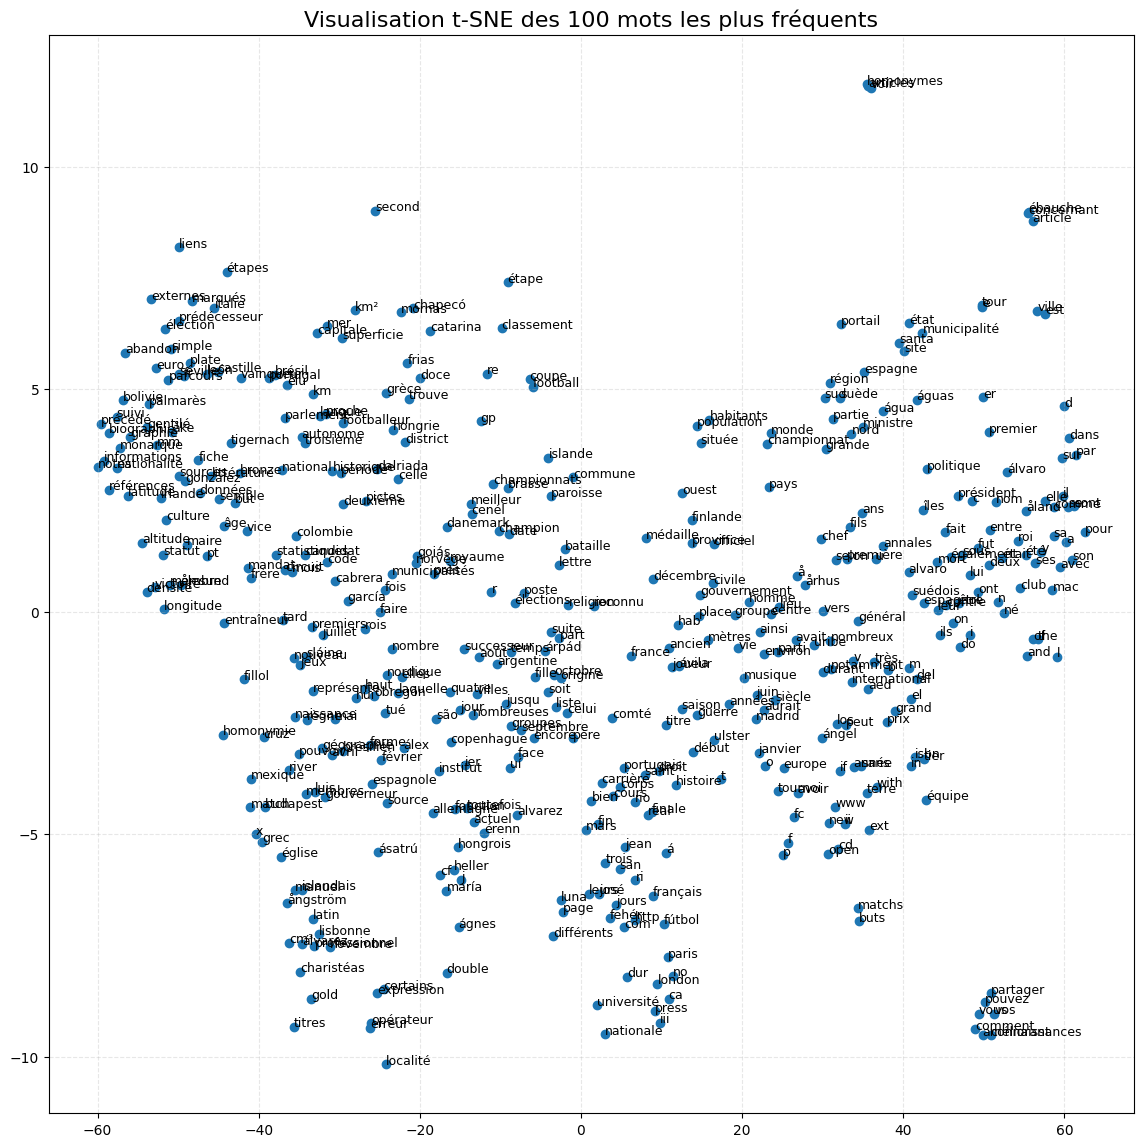

In [56]:
plt.figure(figsize=(14, 14))

plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

for i, word in enumerate(top_100_words):
    x = vectors_2d[i, 0]
    y = vectors_2d[i, 1]
    
    plt.text(x, y, word, fontsize=9)

plt.title("Visualisation t-SNE des 100 mots les plus fréquents", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)

plt.savefig("tsne_visualization.png")
plt.show()

## 5. Classification avec des représentations word2vec

Reprenez ce que vous avez fait dans le TP 2 en prenant des représentations word2vec pour l’entrainement du classifieur.

In [60]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from huggingface_hub import hf_hub_download


col = ['id', 'text', 'label']
train = pd.read_csv('task1-train.csv', sep='\t', names=col)
test = pd.read_csv('task1-testGold.csv', sep='\t', names=col)

train.dropna(subset=['text'], inplace=True)
test.dropna(subset=['text'], inplace=True)

file_path = hf_hub_download(repo_id="Word2vec/wikipedia2vec_frwiki_20180420_300d", filename="frwiki_20180420_300d.txt")
model = KeyedVectors.load_word2vec_format(file_path, binary=False, limit=100000)

def get_sentence_vector(text, model):
    words = simple_preprocess(text)
    valid_vectors = [model[w] for w in words if w in model.key_to_index]
    if len(valid_vectors) > 0:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
X_train = np.vstack([get_sentence_vector(t, model) for t in train['text']])
X_test = np.vstack([get_sentence_vector(t, model) for t in test['text']])

y_train = train['label']
y_test = test['label']
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\naccuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


accuracy: 0.6318
              precision    recall  f1-score   support

       mixed       0.25      0.05      0.08       124
    negative       0.56      0.71      0.62       309
   objective       0.74      0.78      0.76       400
    positive       0.56      0.54      0.55       123

    accuracy                           0.63       956
   macro avg       0.53      0.52      0.50       956
weighted avg       0.60      0.63      0.60       956

